In [1]:
%run init_notebook.py

In [102]:
from src.utils import load_pd_df, save_pd_df
from matplotlib.pyplot import cm

from patsy import dmatrix
import pymc as pm
import arviz as az

from src.pymc_modelling import get_samp

In [125]:
tdet = load_pd_df("det_topics.feather")
tlda = load_pd_df("lda_topics.feather").reset_index()

# plot

In [127]:
tdet_g = tdet.drop('id', axis=1).groupby('date').sum() / tdet.drop('id', axis=1).groupby('date').count().iloc[:,0].values[:,None]
tdet_g = tdet_g.rolling(15).mean().apply(lambda x: (x - x.min()) / (x.max() - x.min()))

tlda_g = tlda.groupby('date').sum() / tlda.groupby('date').count().iloc[:,0].values[:,None]
tlda_g = tlda_g.rolling(15).mean().apply(lambda x: (x - x.min()) / (x.max() - x.min()))

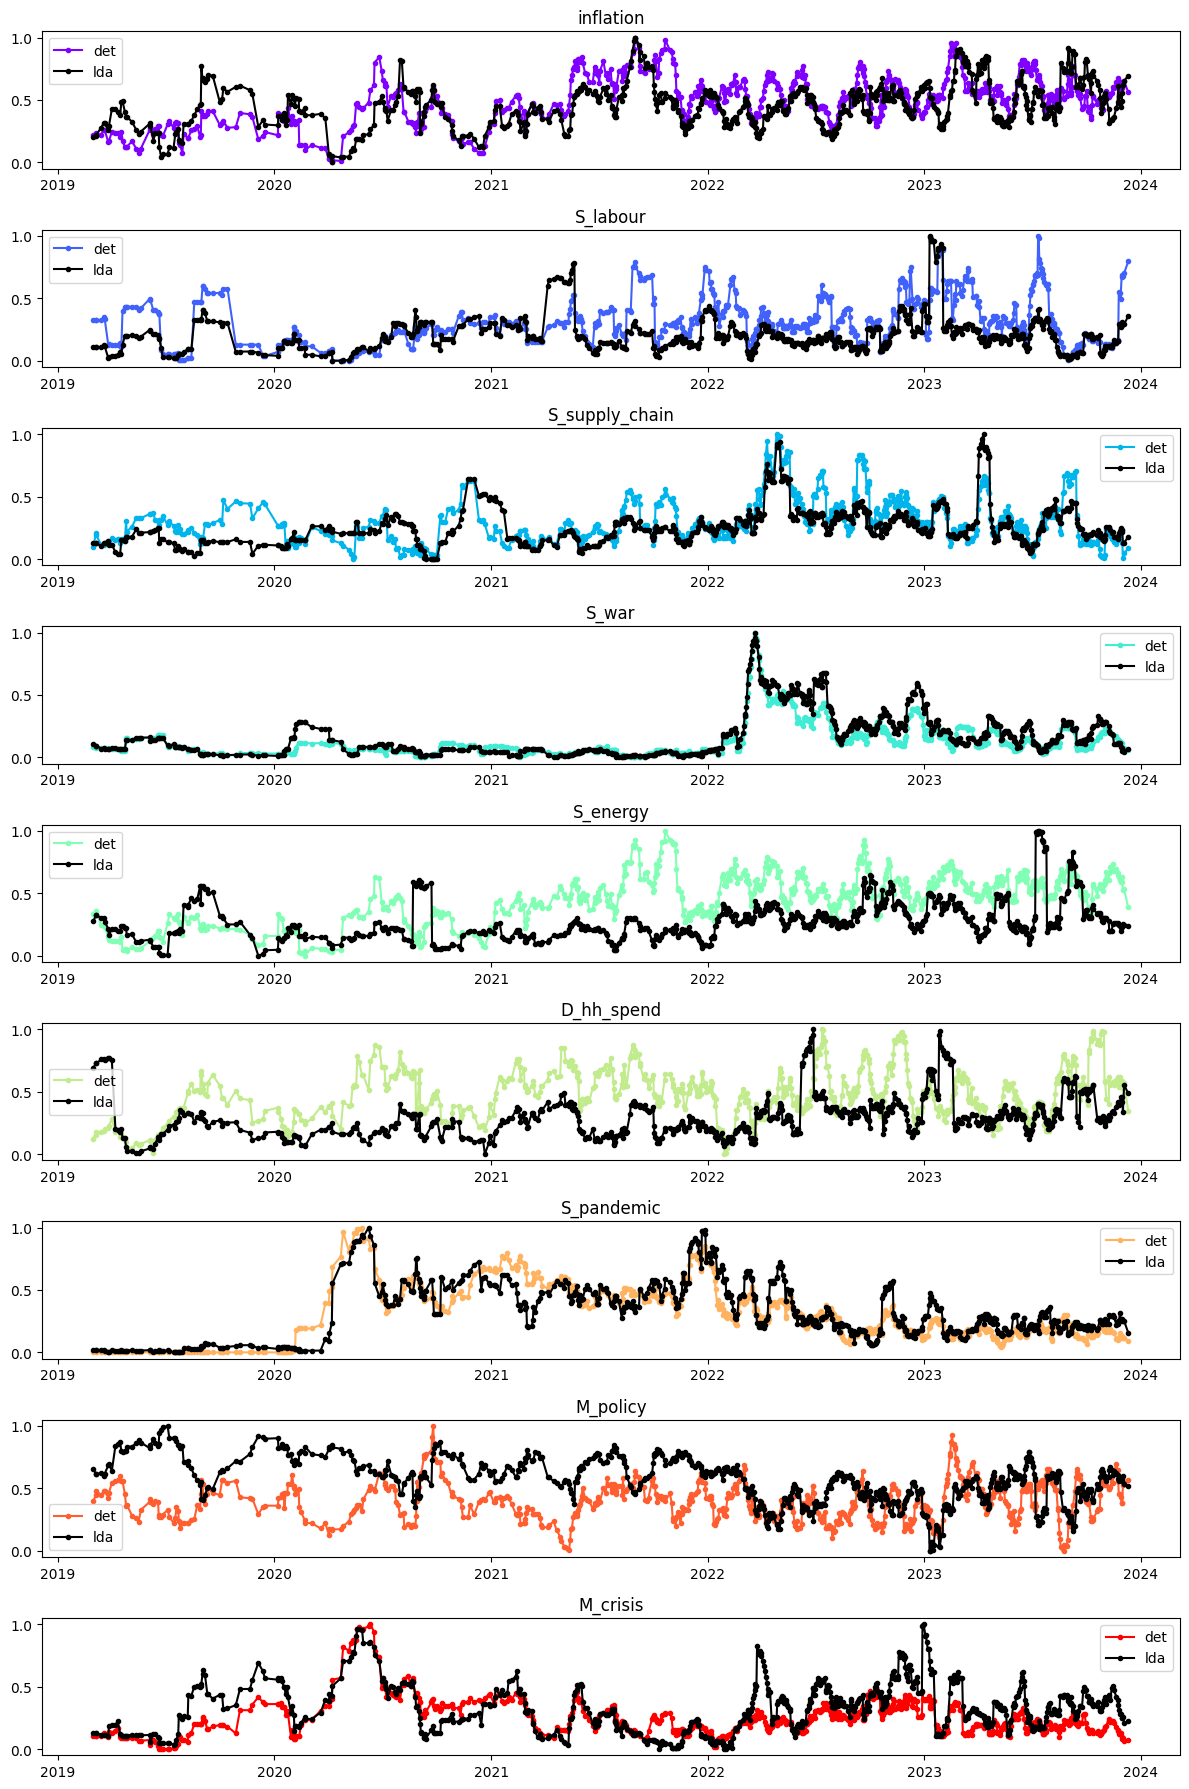

In [7]:
nrows = tdet_g.shape[1]
fig, axes = plt.subplots(nrows, 1, figsize=(12, 2 * nrows))
color = cm.rainbow(np.linspace(0, 1, nrows))

# axes.ravel()[0].plot(df.groupby('date').id.count(), lw=0.2, marker='.')
# axes.ravel()[0].set_title('Inflation article counts')
for i, ax in enumerate(axes.ravel()):
    col = tdet_g.columns[i]
    ax.plot(tdet_g.iloc[:, i], c=color[i], marker='.', )
    ax.plot(tlda_g.loc[:, col], c='black', marker='.',)
    ax.set_title(label=col)
    ax.legend(['det', 'lda'])
            
    
plt.tight_layout()

# smooth

In [80]:
def get_topic_smooth(ser: pd.Series, n_knots: int = 5, is_samp_post_prior: bool = True, **kwargs):
    knot_list = np.linspace(0, len(ser), n_knots+2)[1:-1]
    
    B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True)-1",
    {"cnt": range(len(ser)), "knots": knot_list[1:-1]}
    )
    
    with pm.Model() as mod:
        tau = pm.HalfCauchy("tau", 1) 
        beta = pm.Normal("beta", mu=0, sigma=tau, shape=B.shape[1])
        mu = pm.Deterministic("mu", pm.math.dot(B.T.T, beta))
        sigma = pm.HalfNormal("sigma", 1)
        pm.Normal("likelihood", mu, sigma, observed=g.values)

        trace = pm.sample(1000, nuts_sampler="numpyro", chains=2, **kwargs)
        if is_samp_post_prior:
            prior = pm.sample_prior_predictive()
            post = pm.sample_posterior_predictive(trace)
    
            return mod, prior, trace, post, B
        else:
            return mod, trace, B

In [81]:
def evalute_optimal_smoothing(ser, search_range: range):
    mods, traces = {}, {}
    for k in tqdm([*search_range]):
        mod, trace, _ = get_topic_smooth(
            ser,
            n_knots=k,
            is_samp_post_prior=False,
            return_inferencedata=True,
            idata_kwargs = {'log_likelihood': True}
        )
        
        mods[k] = mod
        traces[k] = trace
        
    df = az.compare(traces)
    return df, mods, traces

In [83]:
# %%capture
dict_compare_az, dict_best_nknot, dict_compare_traces, dict_data_grouped = {}, {}, {}, {}
for col in tlda.drop(['date', 'id'], axis=1).columns:
    
    g = tlda.groupby('date')[col].sum().replace({0: np.nan})
    az_df, mods, traces = evalute_optimal_smoothing(g, search_range=range(30, 55, 5))
    dict_best_nknot[col] = az_df[az_df['rank'] == 0].index[0]
    dict_compare_az[col] = az_df
    dict_compare_traces[col] = traces
    dict_data_grouped[col] = g



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.886570
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.757474
Transforming variables...
Transformation time =  0:00:00.029178
Computing Log Likelihood...
Log Likelihood time =  0:00:00.159208




 20%|████████████████▊                                                                   | 1/5 [00:06<00:25,  6.36s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.860718
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.844232
Transforming variables...
Transformation time =  0:00:00.062807
Computing Log Likelihood...




 40%|█████████████████████████████████▌                                                  | 2/5 [00:12<00:17,  5.98s/it]

Log Likelihood time =  0:00:00.169069


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.856188
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.881220
Transforming variables...
Transformation time =  0:00:00.046907
Computing Log Likelihood...




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:17<00:11,  5.86s/it]

Log Likelihood time =  0:00:00.179606


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.880527
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.400726
Transforming variables...
Transformation time =  0:00:00.058547
Computing Log Likelihood...




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:24<00:06,  6.03s/it]

Log Likelihood time =  0:00:00.160578


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.625974
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.273891
Transforming variables...
Transformation time =  0:00:00.097318
Computing Log Likelihood...




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.22s/it]

Log Likelihood time =  0:00:00.255609



C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecat

Compiling...
Compilation time =  0:00:00.841581
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.686166
Transforming variables...
Transformation time =  0:00:00.015588
Computing Log Likelihood...
Log Likelihood time =  0:00:00.172482




 20%|████████████████▊                                                                   | 1/5 [00:05<00:21,  5.47s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.866659
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.951252
Transforming variables...
Transformation time =  0:00:00.028146
Computing Log Likelihood...
Log Likelihood time =  0:00:00.165155




 40%|█████████████████████████████████▌                                                  | 2/5 [00:11<00:16,  5.66s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.897981
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.022763
Transforming variables...
Transformation time =  0:00:00.031215
Computing Log Likelihood...
Log Likelihood time =  0:00:00.172936




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:17<00:11,  5.78s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.073761
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.174978
Transforming variables...
Transformation time =  0:00:00.024100
Computing Log Likelihood...




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:23<00:06,  6.01s/it]

Log Likelihood time =  0:00:00.202731


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.083150
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.463023
Transforming variables...
Transformation time =  0:00:00.031245
Computing Log Likelihood...




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.42s/it]

Log Likelihood time =  0:00:00.197910



C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\m

Compiling...
Compilation time =  0:00:01.264966
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.806576
Transforming variables...
Transformation time =  0:00:00.018335
Computing Log Likelihood...




 20%|████████████████▊                                                                   | 1/5 [00:07<00:28,  7.10s/it]

Log Likelihood time =  0:00:00.216130


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.882777
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.289186
Transforming variables...
Transformation time =  0:00:00.033328
Computing Log Likelihood...




 40%|█████████████████████████████████▌                                                  | 2/5 [00:13<00:19,  6.63s/it]

Log Likelihood time =  0:00:00.216954


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.953291
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.120220
Transforming variables...
Transformation time =  0:00:00.015625
Computing Log Likelihood...




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:19<00:12,  6.41s/it]

Log Likelihood time =  0:00:00.219011


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.919522
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.192227
Transforming variables...
Transformation time =  0:00:00.031243
Computing Log Likelihood...
Log Likelihood time =  0:00:00.187453




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:25<00:06,  6.30s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.711839
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.954390
Transforming variables...
Transformation time =  0:00:00.031351
Computing Log Likelihood...
Log Likelihood time =  0:00:00.172240




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.46s/it]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is 

Compiling...
Compilation time =  0:00:00.926844
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.835209
Transforming variables...
Transformation time =  0:00:00.031211
Computing Log Likelihood...




 20%|████████████████▊                                                                   | 1/5 [00:05<00:22,  5.74s/it]

Log Likelihood time =  0:00:00.198131


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.899381
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.002966
Transforming variables...
Transformation time =  0:00:00.015038
Computing Log Likelihood...
Log Likelihood time =  0:00:00.187458




 40%|█████████████████████████████████▌                                                  | 2/5 [00:11<00:17,  5.86s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.923620
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.290204
Transforming variables...
Transformation time =  0:00:00.031210
Computing Log Likelihood...




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:17<00:12,  6.05s/it]

Log Likelihood time =  0:00:00.234136


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.909875
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.256120
Transforming variables...
Transformation time =  0:00:00.036018
Computing Log Likelihood...




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:24<00:06,  6.14s/it]

Log Likelihood time =  0:00:00.189319


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.929398
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.734077
Transforming variables...
Transformation time =  0:00:00.017365
Computing Log Likelihood...




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.38s/it]

Log Likelihood time =  0:00:00.200267



C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\m

Compiling...
Compilation time =  0:00:01.263221
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.909535
Transforming variables...
Transformation time =  0:00:00.031277
Computing Log Likelihood...
Log Likelihood time =  0:00:00.160922




 20%|████████████████▊                                                                   | 1/5 [00:06<00:26,  6.55s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.914012
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.436319
Transforming variables...
Transformation time =  0:00:00.020305
Computing Log Likelihood...
Log Likelihood time =  0:00:00.202452




 40%|█████████████████████████████████▌                                                  | 2/5 [00:12<00:19,  6.43s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.898747
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.984599
Transforming variables...
Transformation time =  0:00:00.020718
Computing Log Likelihood...




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:18<00:12,  6.19s/it]

Log Likelihood time =  0:00:00.188335


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.882951
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.189977
Transforming variables...
Transformation time =  0:00:00.031207
Computing Log Likelihood...




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:24<00:06,  6.15s/it]

Log Likelihood time =  0:00:00.184928


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.867412
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.040906
Transforming variables...
Transformation time =  0:00:00.032977
Computing Log Likelihood...
Log Likelihood time =  0:00:00.179289




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.16s/it]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is 

Compiling...
Compilation time =  0:00:00.834317
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.088699
Transforming variables...
Transformation time =  0:00:00.015747
Computing Log Likelihood...




 20%|████████████████▊                                                                   | 1/5 [00:06<00:27,  6.93s/it]

Log Likelihood time =  0:00:00.218142


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.336116
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.164891
Transforming variables...
Transformation time =  0:00:00.031243
Computing Log Likelihood...
Log Likelihood time =  0:00:00.187682




 40%|█████████████████████████████████▌                                                  | 2/5 [00:13<00:20,  6.77s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.868728
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.831529
Transforming variables...
Transformation time =  0:00:00.033691
Computing Log Likelihood...
Log Likelihood time =  0:00:00.177236




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:19<00:12,  6.28s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.946506
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.034636
Transforming variables...
Transformation time =  0:00:00.031274
Computing Log Likelihood...




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:25<00:06,  6.19s/it]

Log Likelihood time =  0:00:00.198088


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.885816
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.166889
Transforming variables...
Transformation time =  0:00:00.031270
Computing Log Likelihood...




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.29s/it]

Log Likelihood time =  0:00:00.193173



C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\m

Compiling...
Compilation time =  0:00:01.077044
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.703492
Transforming variables...
Transformation time =  0:00:00.031308
Computing Log Likelihood...
Log Likelihood time =  0:00:00.171848




 20%|████████████████▊                                                                   | 1/5 [00:05<00:23,  5.95s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.825370
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.892625
Transforming variables...
Transformation time =  0:00:00.031212
Computing Log Likelihood...
Log Likelihood time =  0:00:00.172149




 40%|█████████████████████████████████▌                                                  | 2/5 [00:12<00:19,  6.41s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.833464
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.806395
Transforming variables...
Transformation time =  0:00:00.031551
Computing Log Likelihood...
Log Likelihood time =  0:00:00.176211




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:18<00:12,  6.04s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.497994
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.098071
Transforming variables...
Transformation time =  0:00:00.031247
Computing Log Likelihood...
Log Likelihood time =  0:00:00.172785




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:24<00:06,  6.26s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.844537
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.942792
Transforming variables...
Transformation time =  0:00:00.015619
Computing Log Likelihood...
Log Likelihood time =  0:00:00.172770




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.13s/it]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is 

Compiling...
Compilation time =  0:00:00.859414
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.718685
Transforming variables...
Transformation time =  0:00:00.015624
Computing Log Likelihood...
Log Likelihood time =  0:00:00.172331




 20%|████████████████▊                                                                   | 1/5 [00:05<00:22,  5.53s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.862551
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.872941
Transforming variables...
Transformation time =  0:00:00.031277
Computing Log Likelihood...
Log Likelihood time =  0:00:00.156585


 40%|█████████████████████████████████▌                                                  | 2/5 [00:11<00:16,  5.62s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.859756
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.063540
Transforming variables...
Transformation time =  0:00:00.031246
Computing Log Likelihood...
Log Likelihood time =  0:00:00.172303




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:17<00:11,  5.75s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.812658
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.343752
Transforming variables...
Transformation time =  0:00:00.031247
Computing Log Likelihood...
Log Likelihood time =  0:00:00.156404


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:24<00:06,  6.30s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.821686
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.165035
Transforming variables...
Transformation time =  0:00:00.031240
Computing Log Likelihood...
Log Likelihood time =  0:00:00.172291




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.05s/it]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-p

Compiling...
Compilation time =  0:00:00.843934
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.656848
Transforming variables...
Transformation time =  0:00:00.031275
Computing Log Likelihood...
Log Likelihood time =  0:00:00.156666




 20%|████████████████▊                                                                   | 1/5 [00:05<00:21,  5.47s/it]C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.172068
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.188347
Transforming variables...
Transformation time =  0:00:00.031273
Computing Log Likelihood...




 40%|█████████████████████████████████▌                                                  | 2/5 [00:12<00:19,  6.59s/it]

Log Likelihood time =  0:00:00.187423


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.125269
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.546797
Transforming variables...
Transformation time =  0:00:00.046901
Computing Log Likelihood...




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:20<00:14,  7.18s/it]

Log Likelihood time =  0:00:00.265523


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.984127
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.376943
Transforming variables...
Transformation time =  0:00:00.031246
Computing Log Likelihood...




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:27<00:07,  7.17s/it]

Log Likelihood time =  0:00:00.218701


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.437295
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.687461
Transforming variables...
Transformation time =  0:00:00.031207
Computing Log Likelihood...




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.50s/it]

Log Likelihood time =  0:00:00.265996



C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\LukasGrahl\m

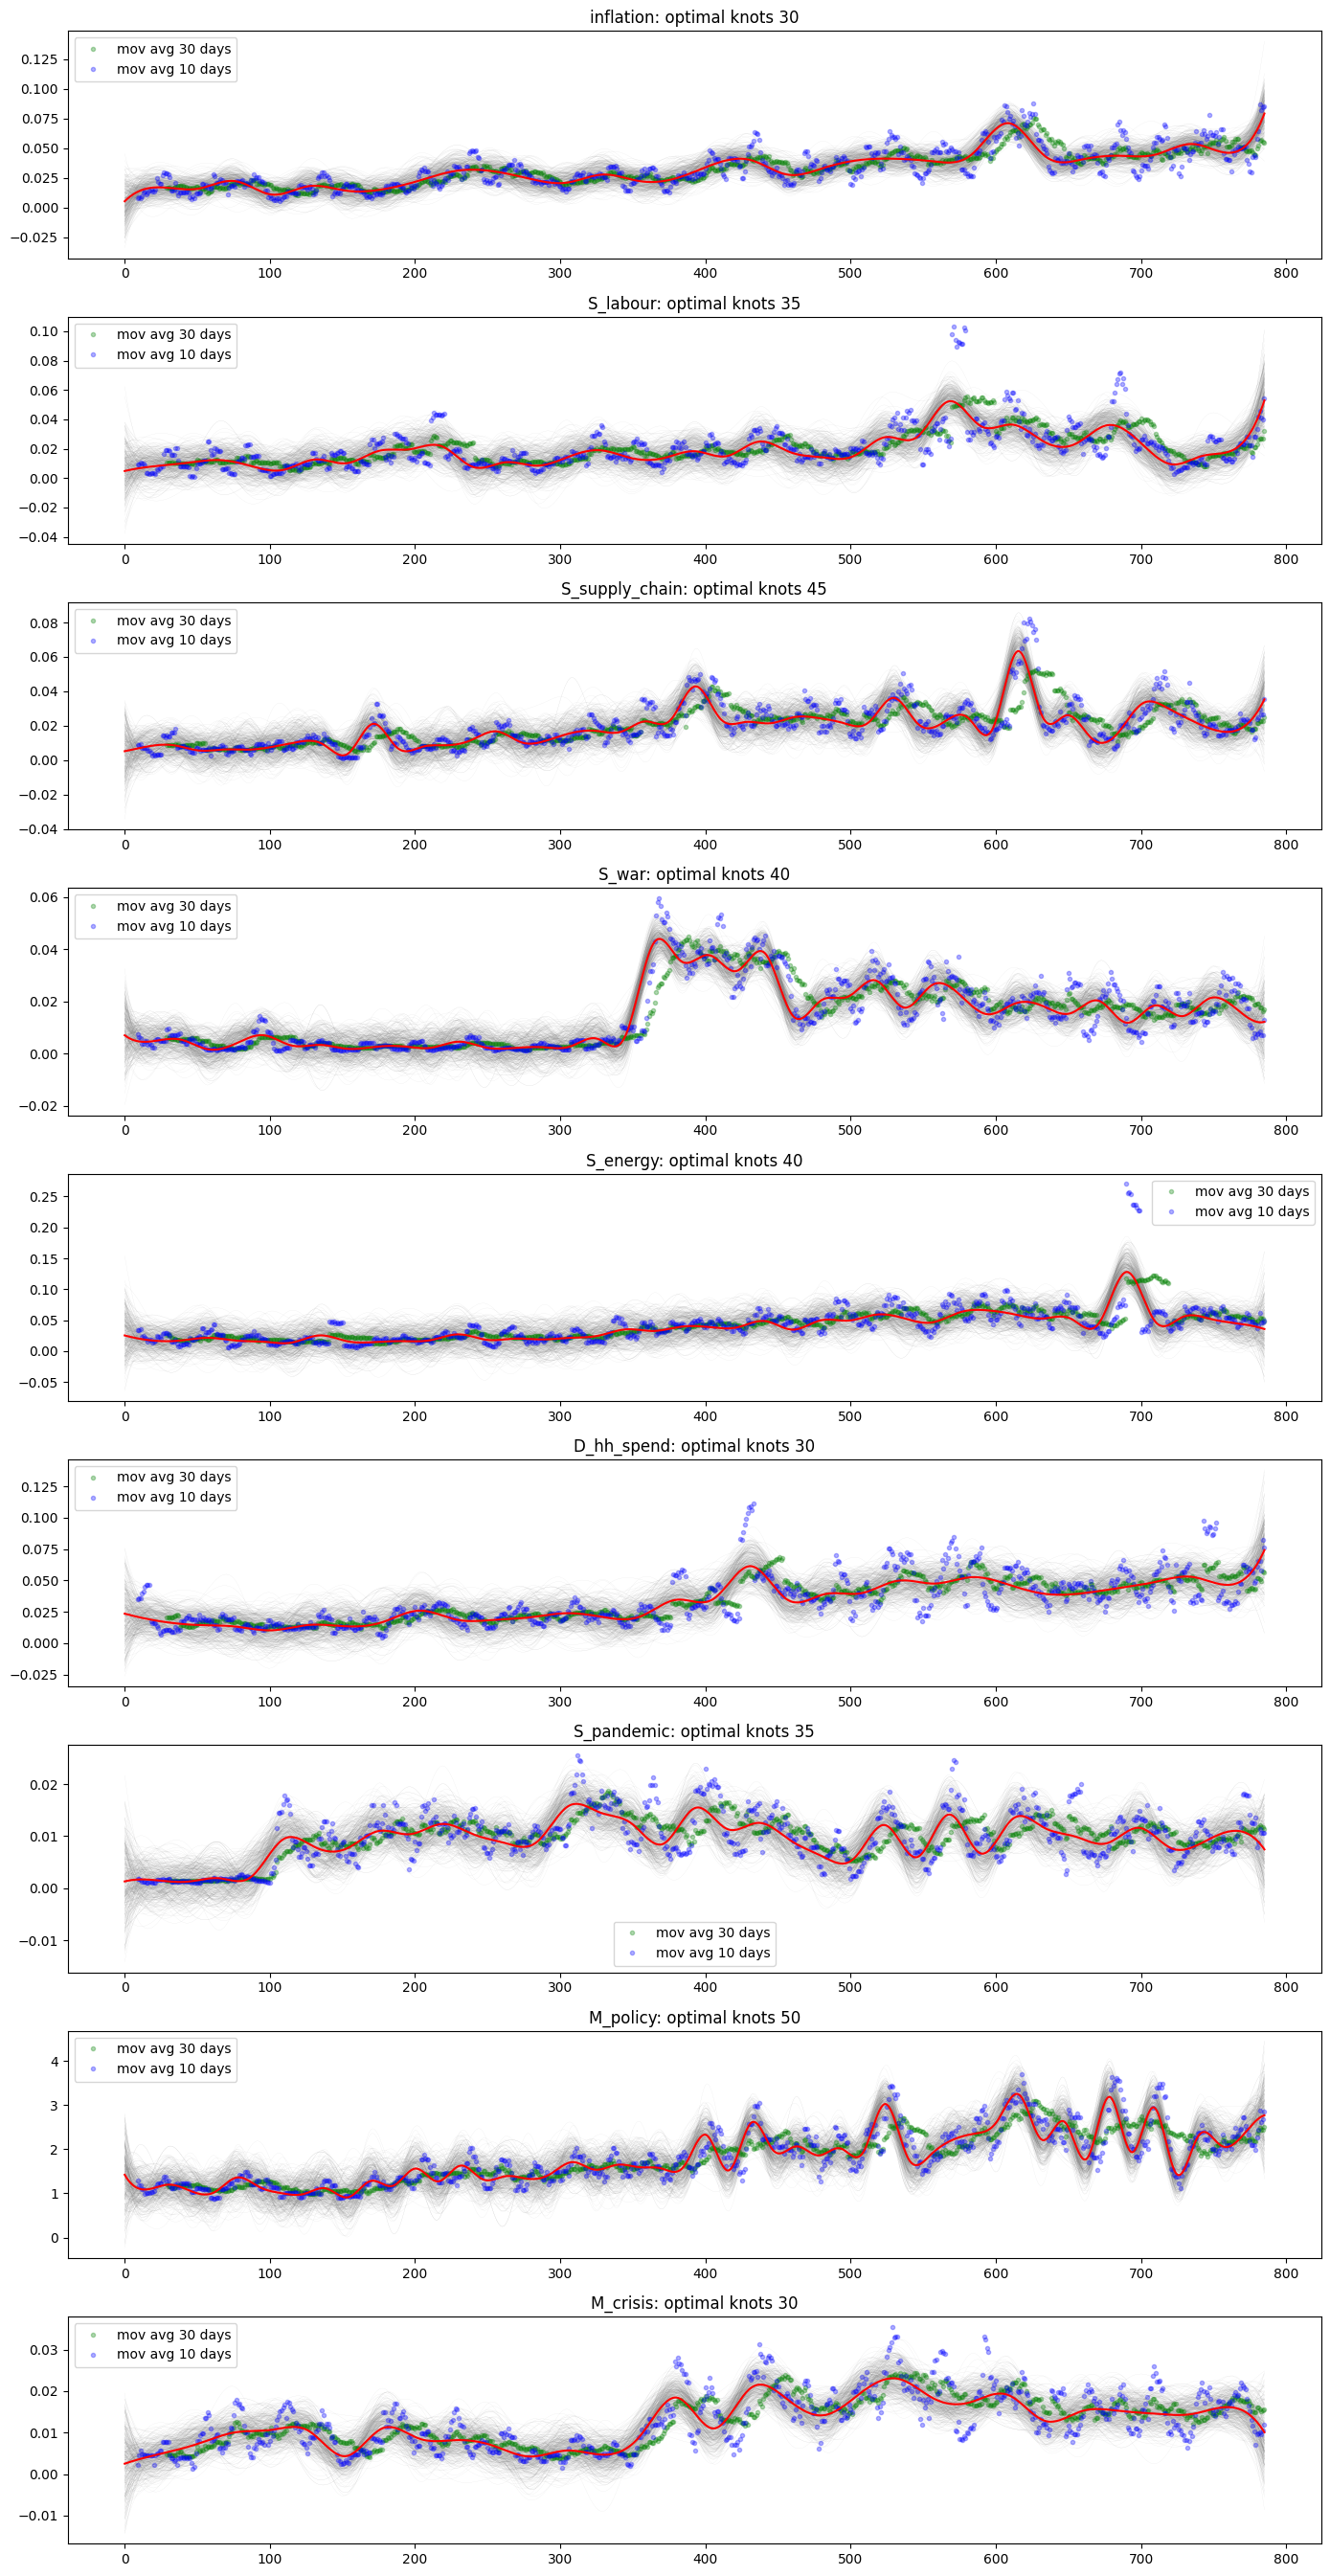

In [122]:
dict_smoothed = {}
dict_plot = {col: [dict_data_grouped[col], dict_compare_traces[col][v]] for col, v in dict_best_nknot.items()}

fig, axes = plt.subplots(len(dict_plot), 1, figsize=(14,3*len(dict_plot)))
for i, _ in enumerate(dict_plot.items()):
    col, _ = _
    data, trace = _
    
    axes.ravel()[i].set_title(f"{col}: optimal knots {dict_best_nknot[col]}") #f"knots_{trace.posterior['beta'].shape[-1]-2}", size=8)
    axes.ravel()[i].plot(
        trace.posterior['mu'][:, get_samp(1_000, 200)].values.reshape(2*200, g.shape[0]).T,
        lw=.1,
        alpha=.3,
        color='grey',
    )
    axes.ravel()[i].plot(data.rolling(30).mean().values, lw=0, marker='.', color='green', alpha=.3, label='mov avg 30 days')
    axes.ravel()[i].plot(data.rolling(10).mean().values, lw=0, marker='.', color='blue', alpha=.3, label='mov avg 10 days')
    axes.ravel()[i].plot(trace.posterior['mu'][:, get_samp(1_000)].values.reshape(2*100, g.shape[0]).T.mean(axis=1), color='red')
    axes.ravel()[i].legend()
    
    dict_smoothed[col] = trace.posterior['mu'][:, get_samp(1_000)].values.reshape(2*100, g.shape[0]).T.mean(axis=1)
plt.tight_layout();

In [123]:
tlda['date'] = tlda['date'].apply(lambda x: datetime(x.year, x.month, x.day))
tlda = tlda.set_index('date').join(pd.DataFrame(dict_smoothed, index=tlda.date.drop_duplicates()).add_suffix('_s'), how='left')

In [124]:

save_pd_df(tlda, 'lda_topics_smooth.feather')